### importing libraries

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage
from typing import TypedDict, Literal,Optional
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os

### setting up LLM API calls validation

In [2]:
load_dotenv()
open_router_api=os.getenv('open_router_api')


In [3]:
model=OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=open_router_api,
)

### defining the schemas for the various LLMs

In [4]:
class task_classifier_schema(BaseModel):
    task_type: Literal['explain','debug','write','docs','other']= Field(description='classify the prompt in various categories')

### Intellicode_SL state for the workflow

In [5]:
task_type= Literal['explain','debug','write','docs','other']

In [6]:
class intellicode_state( TypedDict):

    # user inputs
    prompt:str
    input_code: Optional[str] 

    # context
    messeges: list[BaseMessage]

    # Routing and task info
    task_type: task_type
    task_output: Optional[str]
    change_summary: Optional[str]

    # final response
    final_answer: Optional[str]
    modified_code: Optional[str]

    # metasdata (left empty for future additions)

### node functions 

In [7]:
def task_classifier (state:intellicode_state):
    prompt=f"can you classify the prompt\n \'{state['prompt']}\'\n taking in the following code as context \n {state['input_code']}"

    completion = model.beta.chat.completions.parse(

    model="x-ai/grok-4.1-fast",
    messages=[
        {
        "role": "user",
        "content": prompt
        }
    ],
    response_format=task_classifier_schema,
    )

    task_type=completion.choices[0].message.parsed.task_type
    
    return {'task_type':task_type}

In [8]:
def explain_slm (state:intellicode_state):
    prompt=f"read this prompt : {state['prompt']} and explain the following code \n {state['input_code']} in point wise format"

    completion = model.chat.completions.create(
    
    model="x-ai/grok-4.1-fast",
    messages=[
        {
        "role": "user",
        "content": prompt
        }
    ]
    )
    # extracting the content

    explain=completion.choices[0].message.content
    return {'task_output':explain}

In [ ]:
def debug_code(state: intellicode_state):
    """
    Takes user prompt + input code
    Returns a deeply detailed step-by-step analysis of bugs.
    """
    prompt = f"""
You are a senior debugging expert.

USER PROMPT:
{state['prompt']}

CODE TO DEBUG:
{state['input_code']}

TASK:
1. Detect ALL logical, syntactic, runtime or security bugs.
2. Explain each bug in STEP-BY-STEP format.
3. Provide corrected code at the end.
4. DO NOT summarise here — that happens in debug_summary node.
"""
    completion = model.chat.completions.create(
        model="x-ai/grok-4.1-fast",
        messages=[{"role": "user", "content": prompt}]
    )

    detailed_debug = completion.choices[0].message.content
    return {"task_output": detailed_debug}

    

In [ ]:
def debug_summary(state: intellicode_state):
    """
    Summarizes debug_code output.
    Returns a shorter change summary in bullet-point form.
    """
    prompt = f"""
Summarize the debugging analysis below:

DEBUG OUTPUT:
{state['task_output']}

TASK:
1. Create a short structured summary.
2. Include key bugs found.
3. Include list of specific changes made.
4. Keep it concise (5–10 bullet points).
"""
    completion = model.chat.completions.create(
        model="x-ai/grok-4.1-fast",
        messages=[{"role": "user", "content": prompt}]
    )

    summary = completion.choices[0].message.content
    return {"change_summary": summary}


    

In [ ]:
def write_code(state: intellicode_state):
    """
    Writes new code based on prompt in a step-by-step engineering format.
    """
    prompt = f"""
You are an expert software engineer.

USER PROMPT:
{state['prompt']}

CONTEXT CODE (optional):
{state['input_code']}

TASK:
1. Decide the most appropriate implementation.
2. Explain design decisions step-by-step.
3. Generate clean, production-ready code.
4. DO NOT summarize — summary happens in write_summary node.
"""
    completion = model.chat.completions.create(
        model="x-ai/grok-4.1-fast",
        messages=[{"role": "user", "content": prompt}]
    )

    code_output = completion.choices[0].message.content
    return {"task_output": code_output}


In [ ]:
def write_summary(state: intellicode_state):
    """
    Summarizes the newly generated code.
    """
    prompt = f"""
Summarize the following generated code:

GENERATED CODE:
{state['task_output']}

TASK:
1. Provide a short explanation of what this code does.
2. Explain the design choices in 5–8 bullet points.
3. Mention time complexity if applicable.
"""
    completion = model.chat.completions.create(
        model="x-ai/grok-4.1-fast",
        messages=[{"role": "user", "content": prompt}]
    )

    summary = completion.choices[0].message.content
    return {"change_summary": summary}


In [ ]:
def docs_worker(state: intellicode_state):
    """
    Creates documentation for the code using step-by-step clarity.
    """
    prompt = f"""
Write documentation for the following code

CODE:
{state['input_code']}

TASK:
1. Explain the purpose of the code.
2. Describe how it works step by step.
3. Add usage examples.
4. Add important notes, constraints & assumptions.
5. Use clean, professional technical documentation format.
"""
    completion = model.chat.completions.create(
        model="x-ai/grok-4.1-fast",
        messages=[{"role": "user", "content": prompt}]
    )

    docs_output = completion.choices[0].message.content
    return {"task_output": docs_output}


In [ ]:
def docs_summary(state: intellicode_state):
    """
    Short summary of the documentation created above.
    """
    prompt = f"""
Summarize the documentation below in 5–8 bullet points.

DOCUMENTATION:
{state['task_output']}
"""
    completion = model.chat.completions.create(
        model="x-ai/grok-4.1-fast",
        messages=[{"role": "user", "content": prompt}]
    )

    summary = completion.choices[0].message.content
    return {"change_summary": summary}


In [15]:
def collator (state: intellicode_state):
    prompt=f"can you draft a refined msg for the prompt : {state['prompt']} using the answer {state['task_output']}"

    completion = model.chat.completions.create(
    
    model="x-ai/grok-4.1-fast",
    messages=[
        {
        "role": "user",
        "content": prompt
        }
    ]
    )
    # extracting the content

    final_answer=completion.choices[0].message.content
    return {'final_answer':final_answer}

In [16]:
def unknown ( state: intellicode_state):
    pass

In [17]:
#condion edge selector funtions
def task_router (state: intellicode_state)-> Literal['explain_slm','debug_code','write_code','docs_worker','unknown']:

    if state['task_type']=='explain':
        return 'explain_slm'
    elif state['task_type']=='debug':
        return 'debug_code'
    elif state['task_type']=='write':
        return 'write_code'
    elif state['task_type']=='docs':
        return 'docs_worker'
    else:
        return 'unknown'

### Defining the graph

In [18]:
graph=StateGraph(intellicode_state)


# adding nodes
#
graph.add_node('task_classifier',task_classifier)
graph.add_node('unknown',unknown)
graph.add_node('explain_slm',explain_slm)
graph.add_node('debug_code',debug_code)
graph.add_node('debug_summary',debug_summary)
graph.add_node('write_code',write_code)
graph.add_node('write_summary',write_summary)
graph.add_node('docs_worker',docs_worker)
graph.add_node('docs_summary',docs_summary)
graph.add_node('collator',collator)

# adding edges
#
graph.add_edge(START,'task_classifier')

graph.add_conditional_edges('task_classifier',task_router)

graph.add_edge('unknown','collator')

graph.add_edge('explain_slm','collator')

graph.add_edge('debug_code','debug_summary')
graph.add_edge('debug_summary','collator')

graph.add_edge('write_code','write_summary')
graph.add_edge('write_summary','collator')

graph.add_edge('docs_worker','docs_summary')
graph.add_edge('docs_summary','collator')

graph.add_edge('collator',END)

#compiling the workflow
#
workflow=graph.compile()


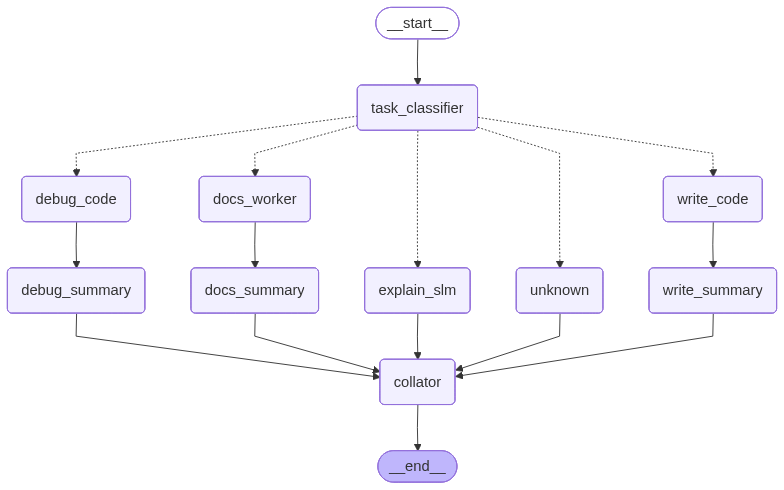

In [19]:
workflow

### test run 

In [20]:
initial_state={''
'prompt':'explain the given code',
'input_code':'''num = int(input("Enter a number: "))

if num > 1:
    for i in range(2, int(num ** 0.5) + 1):
        if num \% i == 0:
            print(num, "is not a prime number")
            break
    else:
        print(num, "is a prime number")
else:
    print(num, "is not a prime number")
'''}

final_state=workflow.invoke(initial_state)

In [21]:
final_state

{'prompt': 'explain the given code',
 'input_code': 'num = int(input("Enter a number: "))\n\nif num > 1:\n    for i in range(2, int(num ** 0.5) + 1):\n        if num \\% i == 0:\n            print(num, "is not a prime number")\n            break\n    else:\n        print(num, "is a prime number")\nelse:\n    print(num, "is not a prime number")\n',
 'task_type': 'explain',
 'task_output': '- **Purpose of the code**: This Python program checks whether a given number is a prime number or not. A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.\n\n- **Line 1: `num = int(input("Enter a number: "))`**\n  - Prompts the user to enter a number.\n  - Converts the input (string) to an integer and stores it in variable `num`.\n\n- **Line 2: `if num > 1:`**\n  - Checks if the number is greater than 1 (primes are only defined for numbers > 1).\n  - If true, proceeds to check for primality; otherwise, skips to the `else` block.\n\n- **Line 3: `for 

In [22]:
print(final_state['final_answer'])

```markdown
**Purpose of the code**: This Python program checks whether a given number is a prime number or not. A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

### Line-by-Line Breakdown
- **Line 1: `num = int(input("Enter a number: "))`**
  - Prompts the user for input.
  - Converts the string input to an integer and stores it in `num`.

- **Line 2: `if num > 1:`**
  - Checks if `num > 1` (prime numbers are defined only for numbers greater than 1).
  - If true, proceeds to primality check; otherwise, jumps to the outer `else`.

- **Line 3: `for i in range(2, int(num ** 0.5) + 1):`**
  - Iterates over potential divisors `i` from 2 to `√num` (inclusive).
  - `num ** 0.5` computes the square root; `int()` floors it; `+1` includes the boundary.
  - **Optimization**: Checks only up to √num, as larger factors would pair with smaller ones already checked.

- **Line 4: `if num % i == 0:`**
  - Uses modulo `%` to test if `i` divides `n

In [23]:
print(final_state['task_output'])

- **Purpose of the code**: This Python program checks whether a given number is a prime number or not. A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

- **Line 1: `num = int(input("Enter a number: "))`**
  - Prompts the user to enter a number.
  - Converts the input (string) to an integer and stores it in variable `num`.

- **Line 2: `if num > 1:`**
  - Checks if the number is greater than 1 (primes are only defined for numbers > 1).
  - If true, proceeds to check for primality; otherwise, skips to the `else` block.

- **Line 3: `for i in range(2, int(num ** 0.5) + 1):`**
  - Loops over potential divisors `i` starting from 2 up to the square root of `num` (inclusive).
  - `num ** 0.5` calculates the square root; `int()` floors it; `+1` ensures inclusivity.
  - Optimization: Only need to check divisors up to √num, as any factor larger than √num would have a corresponding factor smaller than √num.

- **Line 4: `if num % i == 0:`**